In [1]:
import pandas as pd
frame = pd.read_csv('./results/all_predictions_of_search_by_retained.csv')

In [3]:
frame['pos'] = frame['inchi']==frame['inchi_true']
frame['re'] = 100*abs(frame['rt_true']-frame['rt_pred'])/frame['rt_true']

In [5]:
import pandas as pd
import numpy as np
from load_data import SMRTDataset, SMRTDatasetRetained, MetabobaseDataset, RikenDataset, MassBank1Dataset
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib

def ROC(df, threshold):
    # TPR=[]
    # FPR=[]
    TPR=[0]*len(threshold)
    FPR=[0]*len(threshold)

    # df['pos'] = df['inchi']==df['inchi_true']
    P = len(df[df.pos==True])
    N = len(df[df.pos==False])
    # print(P, N)
    for index, thresh in enumerate(tqdm(threshold)):
        df['pos_thresh'] = df['re']<thresh
        TP = len(df[(df['pos']==True)&(df['pos_thresh']==True)])
        FP = len(df[(df['pos']==False)&(df['pos_thresh']==True)])
        TPR[index] = TP/P
        FPR[index] = FP/N
        # TPR.append(TP/P)
        # FPR.append(FP/N)
    print ('Best threshold:', threshold[np.argmax(np.array(TPR)-np.array(FPR))])
    return (TPR, FPR, threshold[np.argmax(np.array(TPR)-np.array(FPR))])
def ROC_AUC(TPR, FPR):
    ROC_AUC=0
    for i in tqdm(range(len(FPR)-1)):
        ROC_AUC+= (FPR[i+1]-FPR[i])*(TPR[i+1]+TPR[i])/2
    return ROC_AUC

threshold=np.arange(0, 200, 0.1)
TPR, FPR, thresh = ROC(frame, threshold)
AUC = ROC_AUC(TPR, FPR)


100%|██████████| 2000/2000 [56:38<00:00,  1.70s/it]


Best threshold: 4.3


100%|██████████| 1999/1999 [00:00<00:00, 1966325.91it/s]


In [6]:
def get_search_space_reduction(df, threshold):
    df['filtered'] = df['re']>threshold
    inchi_list = df[df['pos']==True].inchi
    total, filtered=[0]*len(inchi_list),[0]*len(inchi_list)
    
    for index, inchi in enumerate(tqdm(inchi_list)):
        new_df = df[df['inchi_true']==inchi]
        total[index] = len(new_df)
        filtered[index] = len(new_df[new_df['filtered'] ==True])
        # total.append(len(new_df))
        # filtered.append(len(new_df[new_df['filtered'] ==True]))
    return total, filtered
total, filtered = get_search_space_reduction(frame,thresh)

100%|██████████| 4041/4041 [1:12:18<00:00,  1.07s/it]


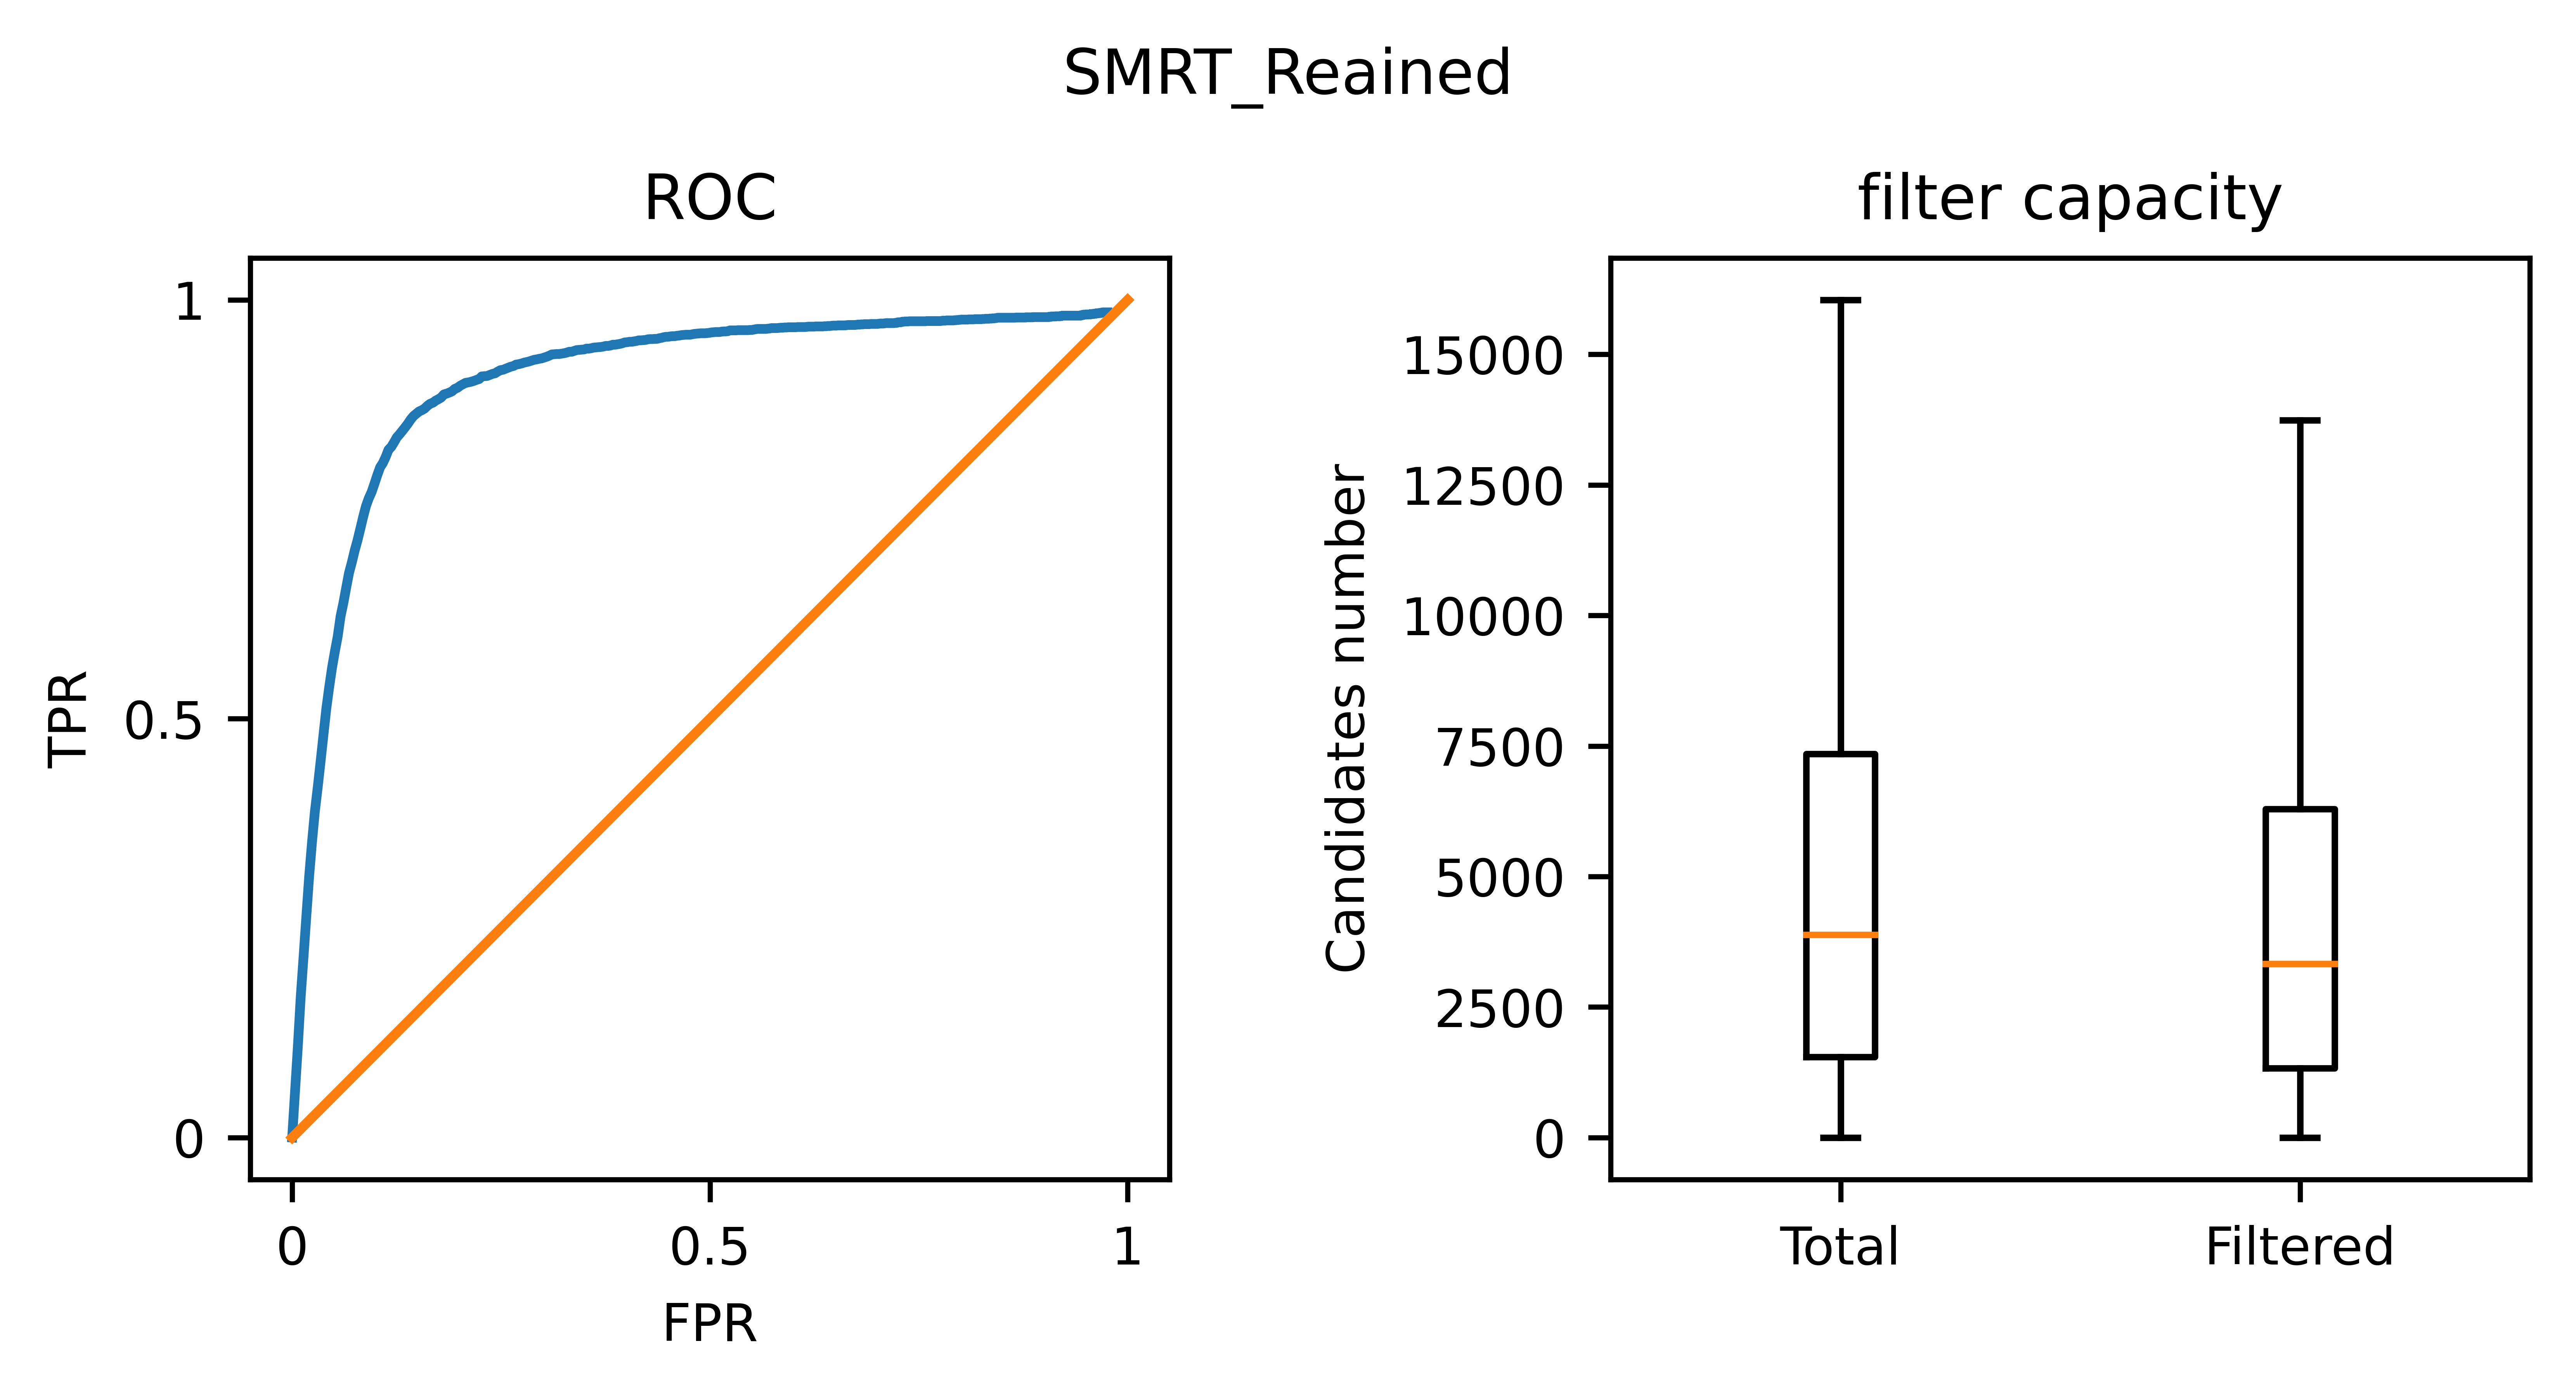

In [12]:
x=[0,1]
y=[0,1]
labels=['Total', 'Filtered']
fig, axs = plt.subplots(1,2, figsize=(6, 3.2), sharey=False, dpi=1200)
i=0
matplotlib.rcParams.update({'font.size': 8})
# for ds in [ds_name]:
    #print(st.mean(RF[ds]))
axs[0].plot(FPR, TPR)
axs[0].plot(x,y)
axs[0].set_yticks([0,0.5, 1])
axs[0].set_xticks([0,0.5, 1])
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[0].set_yticklabels(['0', '0.5', '1'])
axs[0].set_xticklabels(['0', '0.5', '1'])
axs[0].set_title('ROC')


axs[1].boxplot((total, filtered), showfliers=False)
axs[1].set_xticklabels(labels, fontsize=8)
axs[1].set_ylabel('Candidates number')
fig.tight_layout(pad=3.0)
axs[1].set_title('filter capacity')
fig.suptitle('SMRT_Reained')
plt.savefig(f'./figs/retained_ROC_AUC={AUC}_threshold:{thresh}.svg',)

In [9]:
plt.savefig(f'./figs/retained_ROC_AUC={AUC}_threshold:{thresh}.svg',)

<Figure size 640x480 with 0 Axes>

In [ ]:
axs[0].plot(FPR, TPR)
axs[0].plot(x,y)
axs[0].set_yticks([0,0.5, 1])
axs[0].set_xticks([0,0.5, 1])
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[0].set_yticklabels(['0', '0.5', '1'])
axs[0].set_xticklabels(['0', '0.5', '1'])
axs[0].set_title('ROC')

axs[1].boxplot((total, filtered), showfliers=False)
axs[1].set_xticklabels(labels, fontsize=8)
axs[1].set_ylabel('No candidates')
axs[1].set_title('filter capacity')

fig.suptitle('Eawag_XBridgeC18')
fig.tight_layout(pad=3.0)
plt.savefig(f'./figs/retained_ROC_AUC={AUC}_threshold:{thresh}.svg',)

In [36]:

import multiprocessing
from functools import partial
from multiprocessing import Pool,Manager




def get_filter(inchi,total,filtered):
    new_df = frame[frame['inchi_true']==inchi]
    total.append(len(new_df))
    filtered.append(len(new_df[new_df['filtered'] ==True]))

def get_search_space_reduction(df, threshold):
   
    # input_frame.append(df)
    frame['filtered'] = frame['re']>thresh
    inchi_list = frame[frame['pos']==True].inchi
    total, filtered=[0]*len(inchi_list),[0]*len(inchi_list)
    total = Manager().list(total)
    filtered = Manager().list(filtered)
    print('5')
    # input_frame = Manager().list(input_frame)
    partial_filter = partial(get_filter,total=total,filtered=filtered)
    print('x')
    with Pool(processes=16) as pool:
        list(tqdm(pool.imap(partial_filter, inchi_list), total=len(inchi_list)))
    return total, filtered

total, filtered = get_search_space_reduction(frame,thresh)
# returns = get_search_space_reduction(frame,thresh)

KeyboardInterrupt: 